# Advanced Derivatives
## Grouop Project
### Group Members:
- Edoardo Nicoletti 87537
- Alfonso Salcines Gomez Pardo
- Riccardo Mauli
- Zacch Lines

In [184]:
import numpy as np
from financepy.utils import OptionTypes
from financepy.products.equity import bs_value, bs_delta
import pandas as pd
import matplotlib.pyplot as plt

### (a)

In [185]:
# Parameters
S = np.array([100])  # Initial share price (as an array)
K = 100              # Strike price
r = 0.05             # Risk-free interest rate
q = 0.0              # Dividend yield
sigma = 0.2          # Volatility
T = 1.0              # Time to expiry in years

# Directly use the bs_value and bs_delta functions for speed
v_0 = bs_value(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)
delta_0 = bs_delta(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)

print(f"Call Option Value: {v_0}")
print(f"Call Option Delta: {delta_0}")

Call Option Value: 10.450575619322274
Call Option Delta: 0.6368305904551367


In [186]:
def OptionSim(K, S_0, r, mu, sigma, T, N):
    
    dt = 1 / N  # Length of each hedging period in years
    timesteps = int(T * N)  # Total number of timesteps

    # Simulate share price path using lognormal dynamics
    Z = np.random.normal(0, 1, timesteps)
    increments = (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
    log_S = np.log(S_0) + np.cumsum(increments)
    S = np.exp(log_S)
    S = np.insert(S, 0, S_0)

    # Initial option value and delta
    v_0 = bs_value(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)
    delta_0 = bs_delta(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)

    # Initialize portfolio to match initial option value
    shares_held = -delta_0  # To offset the option's delta risk
    cash_balance = v_0 - (shares_held * S_0)  # Initial portfolio value matches the option value

    # Delta hedging process
    for t in range(timesteps):
        T_remaining = T - t * dt
        delta = bs_delta(S[t], T_remaining, K, r, 0, sigma, OptionTypes.EUROPEAN_CALL.value)
        #print(delta)
        shares_to_buy = delta - shares_held
        #print(shares_to_buy)
        cash_balance -= shares_to_buy * S[t]
        shares_held = delta
        cash_balance *= (np.exp(r * dt))

    # Calculate final portfolio value and replicating error
    S_T = S[-1]
    option_payoff = max(S_T - K, 0)
    portfolio_value = shares_held * S_T + cash_balance
    replicating_error = portfolio_value - option_payoff

    return S_T, option_payoff, shares_held, cash_balance, portfolio_value, replicating_error

In [187]:
mu = 0.05     # Drift of the share price
N = 252         # Hedging frequency (daily)

# Run the delta hedging simulation
result = OptionSim(K, S[0], r, mu, sigma, T, N)

# Print the result
print(f"Terminal Share Price (S(T)): {result[0]:.2f}")
print(f"Call Option Payoff: {result[1]:.2f}")
print(f"Number of Shares Held: {result[2]:.2f}")
print(f"Cash Balance: {result[3]:.2f}")
print(f"Total Portfolio Value: {result[4]:.2f}")
print(f"Replicating Error: {result[5]:.2f}")

Terminal Share Price (S(T)): 115.21
Call Option Payoff: 15.21
Number of Shares Held: 1.00
Cash Balance: -100.52
Total Portfolio Value: 14.69
Replicating Error: -0.52


In [188]:
def run_simulations(K, S_0, r, mu, sigma, T, N, num_paths=10000):
    results = []  # List to store the results of each path

    for _ in range(num_paths):
        # Run OptionSim for each path and store the replicating error
        terminal_share_price, option_payoff, shares_held, cash_balance, portfolio_value, replicating_error = OptionSim(K, S_0, r, mu, sigma, T, N)
        results.append((terminal_share_price, option_payoff, shares_held, cash_balance, portfolio_value, replicating_error))

    # Convert results to a DataFrame for easier analysis
    df_results = pd.DataFrame(results, columns=["Terminal Share Price", "Option Payoff", "Shares Held", "Cash Balance", "Portfolio Value", "Replicating Error"])

    return df_results

In [189]:
# Run the delta hedging simulation over 10,000 different paths
df_results = run_simulations(K, S[0], r, mu, sigma, T, N, num_paths=10000)

# Display the first few rows of the results
df_results.head(3)

,Terminal Share Price,Option Payoff,Shares Held,Cash Balance,Portfolio Value,Replicating Error
0,87.680776,0.0,0.000000,-0.556877,-0.556877,-0.556877
1,73.669177,0.0,0.000000,0.005163,0.005163,0.005163
2,94.255729,0.0,0.000078,-0.232320,-0.224971,-0.224971


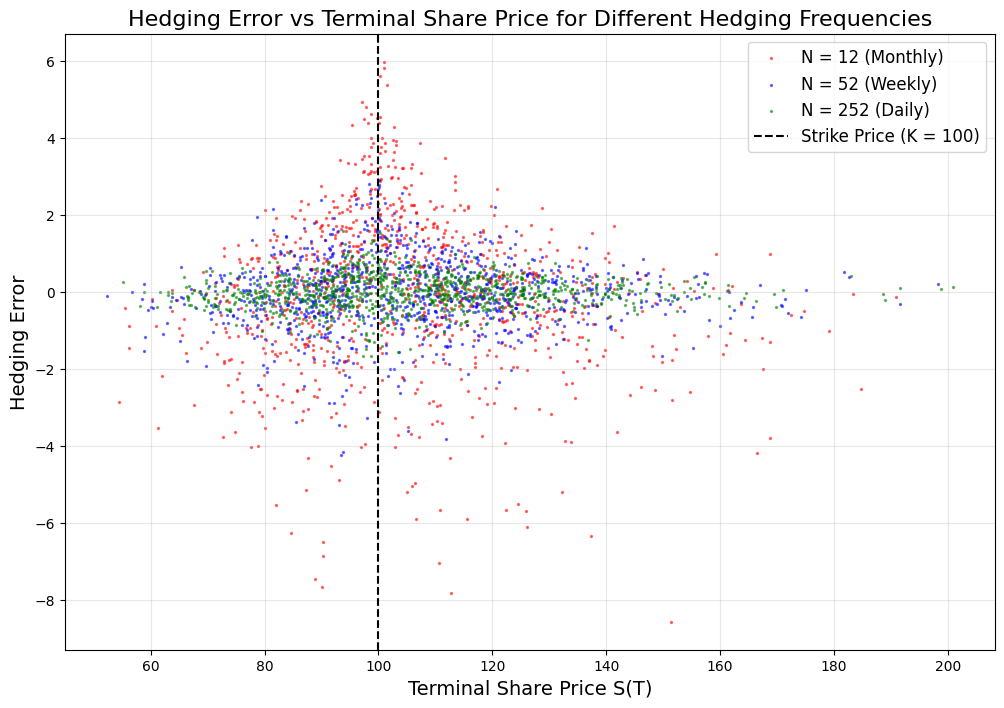

In [216]:
# Different hedging frequencies
N_values = [12, 52, 252]  # Monthly, weekly, daily
num_paths = 1000

# Run simulations for different hedging frequencies and store results
results = {}

for N in N_values:
    df_results = run_simulations(K, S[0], r, mu, sigma, T, N, num_paths=num_paths)
    results[N] = df_results

# Plotting the hedging error vs terminal share price for different N values
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green']
labels = ['N = 12 (Monthly)', 'N = 52 (Weekly)', 'N = 252 (Daily)']

for i, N in enumerate(N_values):
    plt.scatter(results[N]["Terminal Share Price"], results[N]["Replicating Error"],
                color=colors[i], s=2, alpha=0.5, label=labels[i])  # Small dots (s=5)

# Draw a vertical line at the strike price
plt.axvline(x=K, color='black', linestyle='--', linewidth=1.5, label=f"Strike Price (K = {K})")

# Add plot labels and legend
plt.title("Hedging Error vs Terminal Share Price for Different Hedging Frequencies", fontsize=16)
plt.xlabel("Terminal Share Price S(T)", fontsize=14)
plt.ylabel("Hedging Error", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [217]:
# Calculate and display the mean and variance of hedging error for each N value
summary_results = []

for N in N_values:
    mean_error = abs(results[N]["Replicating Error"]).mean()
    variance_error = abs(results[N]["Replicating Error"]).var()
    summary_results.append([N, mean_error, variance_error])

# Create a DataFrame for the summary results
summary_df = pd.DataFrame(summary_results, columns=["Hedging Frequency (N)", "Mean Hedging Error", "Variance of Hedging Error"])
summary_df.set_index("Hedging Frequency (N)", inplace=True)
display(summary_df)

,Mean Hedging Error,Variance of Hedging Error
Hedging Frequency (N),,
12,1.456821,1.686635
52,0.690918,0.385112
252,0.331212,0.083900


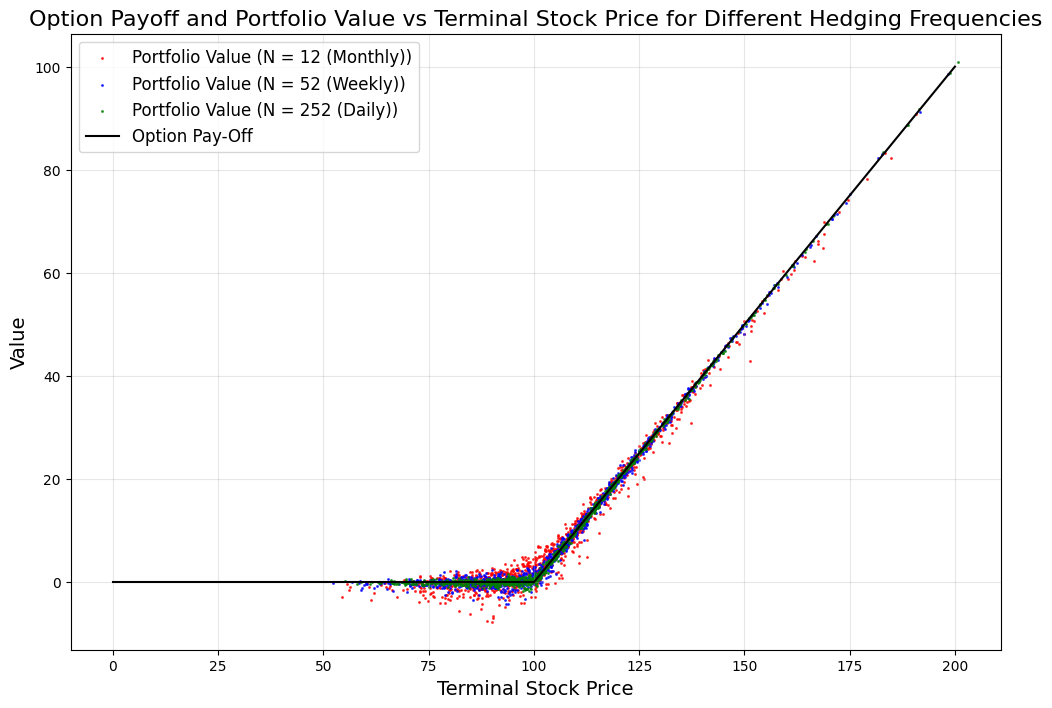

In [218]:
# Plot option payoff and portfolio value vs stock price for different N values
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green']
labels = ['N = 12 (Monthly)', 'N = 52 (Weekly)', 'N = 252 (Daily)']

for i, N in enumerate(N_values):
    plt.scatter(results[N]["Terminal Share Price"], results[N]["Portfolio Value"], color=colors[i], alpha=0.7, s=5, marker='.', label=f"Portfolio Value ({labels[i]})")

# Add a black line for value = 0 to 100
plt.plot([0, 100], [0, 0], color='black', linestyle='-', linewidth=1.5, label="Option Pay-Off")
plt.plot([100, 200], [0, 100], color='black', linestyle='-', linewidth=1.5)

# Add plot labels and legend
plt.title("Option Payoff and Portfolio Value vs Terminal Stock Price for Different Hedging Frequencies", fontsize=16)
plt.xlabel("Terminal Stock Price", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()